In [1]:
import pandas as pd
import requests
import pprint
import json
import time
from pandas import json_normalize
import ast
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None) ## 셀 최대 너비 제한 해제

In [2]:
units_df = pd.read_csv('C:/Users/rlagk/OneDrive/문서/ML/특성과 챔피언 컬럼 붙인 테이블.csv')
units_df.columns

Index(['gameId', 'game_datetime', 'game_length', 'game_version', 'puuid',
       'placement', 'last_round', 'level', '이타심', '거대 괴수', '난동꾼', '귀인', '혼령',
       '먹그림자', '신화', '정령 주술사', '이야기꾼', '재주꾼', '암영', '숲지기', '필연', '기원자', '사신',
       '저격수', '파수꾼', '예술가', '용군주', '호걸', '천계', '연인', '현자', '비전 마법사', '행운',
       '도자기', '결투가', '시비르', '리븐', '쉔', '탐 켄치', '갈리오', '카이사', '사일러스', '우디르',
       '케일', '케이틀린', '렉사이', '잭스', '아트록스', '킨드레드', '세나', '나르', '오른', '아지르',
       '잔나', '소라카', '다이애나', '흐웨이', '라칸', '오공', '애니', '릴리아', '리산드라', '자이라',
       '모르가나', '카직스', '요네', '케인', '니코', '바드', '조이', '리 신', '이렐리아', '코그모',
       '일라오이', '야스오', '키아나', '볼리베어', '트리스타나', '애쉬', '노틸러스', '요릭', '알룬', '세트',
       '아리', '럭스', '아무무', '신드라', '코부코', '다리우스', '아펠리오스', '쓰레쉬', '초가스', '말파이트',
       '가렌', '티모', '자야', 'Combination', 'unit_based_cluster',
       'traits_based_cluster', 'units_and_traits_cluster'],
      dtype='object')

In [3]:
# 기존 데이터프레임을 뒤에서 join 해주기 위해 그대로 두어야하므로 복사하여 combination_clustering 변수에 할당

combination_clustering = units_df.copy()

# '시비르'부터 '자야'까지의 컬럼값이 0인 경우를 제외하고 모두 1로 변경

combination_clustering.loc[:, '이타심':'자야'] = combination_clustering.loc[:, '이타심':'자야'].applymap(lambda x: 0 if x == 0 else 1)
              # 시비르 컬럼부터 자야 컬럼까지 모든행을 선택                         # 선택한 모든 데이터(applymap)에 람다 함수를 적용
                                                                                 # 여기서 람다 함수는 x가 0이면 0 나머지는 1로 치환
# 작업 확인
combination_clustering.columns

Index(['gameId', 'game_datetime', 'game_length', 'game_version', 'puuid',
       'placement', 'last_round', 'level', '이타심', '거대 괴수', '난동꾼', '귀인', '혼령',
       '먹그림자', '신화', '정령 주술사', '이야기꾼', '재주꾼', '암영', '숲지기', '필연', '기원자', '사신',
       '저격수', '파수꾼', '예술가', '용군주', '호걸', '천계', '연인', '현자', '비전 마법사', '행운',
       '도자기', '결투가', '시비르', '리븐', '쉔', '탐 켄치', '갈리오', '카이사', '사일러스', '우디르',
       '케일', '케이틀린', '렉사이', '잭스', '아트록스', '킨드레드', '세나', '나르', '오른', '아지르',
       '잔나', '소라카', '다이애나', '흐웨이', '라칸', '오공', '애니', '릴리아', '리산드라', '자이라',
       '모르가나', '카직스', '요네', '케인', '니코', '바드', '조이', '리 신', '이렐리아', '코그모',
       '일라오이', '야스오', '키아나', '볼리베어', '트리스타나', '애쉬', '노틸러스', '요릭', '알룬', '세트',
       '아리', '럭스', '아무무', '신드라', '코부코', '다리우스', '아펠리오스', '쓰레쉬', '초가스', '말파이트',
       '가렌', '티모', '자야', 'Combination', 'unit_based_cluster',
       'traits_based_cluster', 'units_and_traits_cluster'],
      dtype='object')

In [4]:
base_df=combination_clustering.drop(['gameId', 'game_datetime', 'game_length', 'game_version', 'puuid',
       'placement', 'last_round','Combination', 'level'], axis=1)

In [5]:
cols=['이타심', '거대 괴수', '난동꾼', '귀인', '혼령',
       '먹그림자', '신화', '정령 주술사', '이야기꾼', '재주꾼', '암영', '숲지기', '필연', '기원자', '사신',
       '저격수', '파수꾼', '예술가', '용군주', '호걸', '천계', '연인', '현자', '비전 마법사', '행운',
       '도자기', '결투가','시비르', '리븐', '쉔', '탐 켄치', '갈리오',
       '카이사', '사일러스', '우디르', '케일', '케이틀린', '렉사이', '잭스', '아트록스', '킨드레드', '세나',
       '나르', '오른', '아지르', '잔나', '소라카', '다이애나', '흐웨이', '라칸', '오공', '애니', '릴리아',
       '리산드라', '자이라', '모르가나', '카직스', '요네', '케인', '니코', '바드', '조이', '리 신',
       '이렐리아', '코그모', '일라오이', '야스오', '키아나', '볼리베어', '트리스타나', '애쉬', '노틸러스',
       '요릭', '알룬', '세트', '아리', '럭스', '아무무', '신드라', '코부코', '다리우스', '아펠리오스',
       '쓰레쉬', '초가스', '말파이트', '가렌', '티모', '자야']
base_df['combined'] =base_df[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

In [6]:
base_df2 = base_df['combined']

In [7]:
base_df2 = base_df2.reset_index()

In [8]:
from sklearn.preprocessing import StandardScaler
features = ['combined']
# Separating out the features
x = base_df2.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

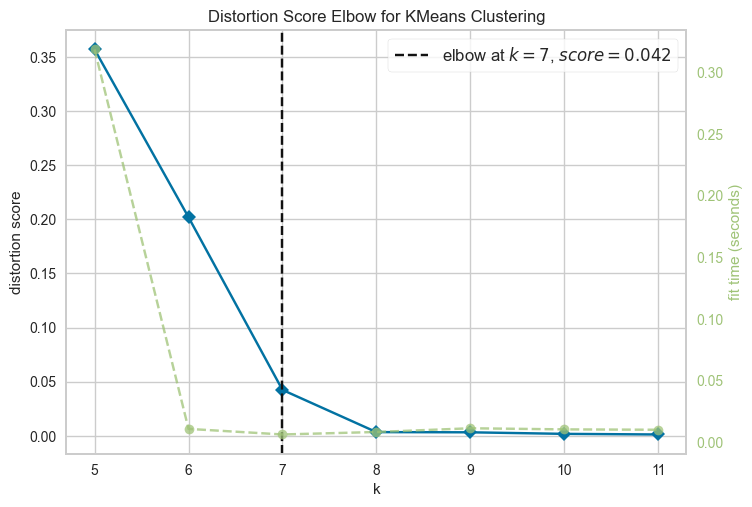

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# using yellowbrick library 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,12)) # set K range 

visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show() 

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42, n_init="auto").fit(x)

# 결과 확인
result_by_sklearn = base_df2.copy()
result_by_sklearn["cluster"] = kmeans.labels_
result_by_sklearn.head()

,index,combined,cluster
0,0,0111000111000000000000000001111111110000000000000000000000000000000000000000000000000000,5
1,1,0010110000010001100000000000000000001111111110000000000000000000000000000000000000000000,4
2,2,1100000100010100011111100000000000100000000111111110000000000000000000000000000000000000,3
3,3,0110001100000100010001000000001001100000000100001101110000000000000000000000000000000000,5
4,4,0110000110000000001000100000100100110000000101010000001100000000000000000000000000000000,5


In [14]:
result_by_sklearn=result_by_sklearn.drop(['index'], axis=1)

In [15]:
r_df = result_by_sklearn.groupby(['cluster']).count()

<Axes: xlabel='cluster'>

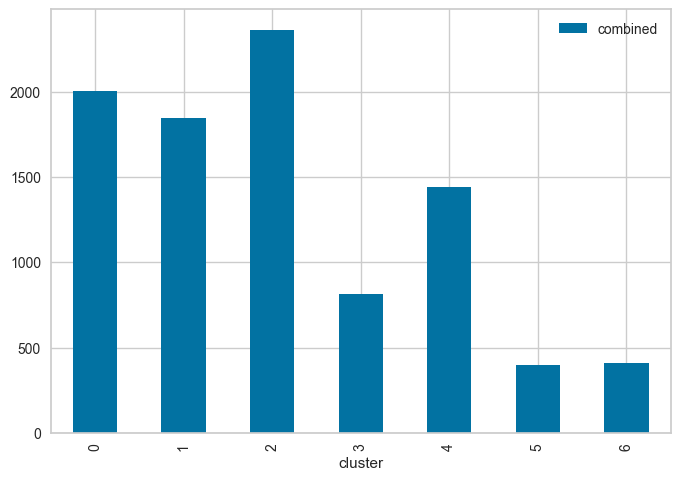

In [17]:
result_by_sklearn.groupby(['cluster']).count().plot(kind='bar')

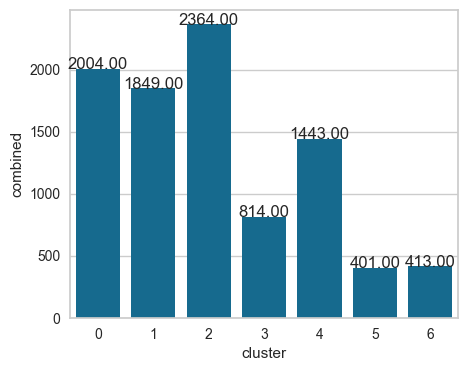

In [18]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(5,4) )

# 바차트 그리기
sns.barplot(x = r_df.index, y = r_df['combined'])

# 값 가져와서 -> 텍스트 추가하기
for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():.2f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

In [20]:
base_df = pd.concat([base_df, result_by_sklearn['cluster']], axis=1)
base_df

,이타심,거대 괴수,난동꾼,귀인,혼령,먹그림자,신화,정령 주술사,이야기꾼,재주꾼,...,초가스,말파이트,가렌,티모,자야,unit_based_cluster,traits_based_cluster,units_and_traits_cluster,combined,cluster
0,0,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,5,13,1,0111000111000000000000000001111111110000000000000000000000000000000000000000000000000000,5
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,16,18,15,0010110000010001100000000000000000001111111110000000000000000000000000000000000000000000,4
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,18,11,12,1100000100010100011111100000000000100000000111111110000000000000000000000000000000000000,3
3,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,11,15,0,0110001100000100010001000000001001100000000100001101110000000000000000000000000000000000,5
4,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,12,3,10,0110000110000000001000100000100100110000000101010000001100000000000000000000000000000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,2,8,1010000010000000011111100110100100010000000000111110010000000011000000000000000000000000,1
9284,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,18,11,12,1100000100010100001111100000000000100000000111110110000100000000000000000000000000000000,3
9285,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,6,0100000000001001100000010100000000000000000000000000010000000000010000100000111001100000,2
9286,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,6,9,4,0000110000000001100000000000010000001011010000000000000100100000010000000000000000000000,0


In [21]:
base_df = base_df.loc[:,~base_df.columns.duplicated()]
base_df

,이타심,거대 괴수,난동꾼,귀인,혼령,먹그림자,신화,정령 주술사,이야기꾼,재주꾼,...,초가스,말파이트,가렌,티모,자야,unit_based_cluster,traits_based_cluster,units_and_traits_cluster,combined,cluster
0,0,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,5,13,1,0111000111000000000000000001111111110000000000000000000000000000000000000000000000000000,5
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,16,18,15,0010110000010001100000000000000000001111111110000000000000000000000000000000000000000000,4
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,18,11,12,1100000100010100011111100000000000100000000111111110000000000000000000000000000000000000,3
3,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,11,15,0,0110001100000100010001000000001001100000000100001101110000000000000000000000000000000000,5
4,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,12,3,10,0110000110000000001000100000100100110000000101010000001100000000000000000000000000000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,2,8,1010000010000000011111100110100100010000000000111110010000000011000000000000000000000000,1
9284,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,18,11,12,1100000100010100001111100000000000100000000111110110000100000000000000000000000000000000,3
9285,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,6,0100000000001001100000010100000000000000000000000000010000000000010000100000111001100000,2
9286,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,6,9,4,0000110000000001100000000000010000001011010000000000000100100000010000000000000000000000,0


In [22]:
base_df.drop(columns=['traits_based_cluster'], inplace=True)
base_df.drop(columns=['units_and_traits_cluster'], inplace=True)
base_df.drop(columns=['combined'], inplace=True)

In [26]:
base_df.drop(columns=['cluster'], inplace=True)

In [27]:
base_df

,이타심,거대 괴수,난동꾼,귀인,혼령,먹그림자,신화,정령 주술사,이야기꾼,재주꾼,...,코부코,다리우스,아펠리오스,쓰레쉬,초가스,말파이트,가렌,티모,자야,unit_based_cluster
0,0,1,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,5
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,18
3,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,11
4,0,1,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
9284,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,18
9285,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
9286,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


In [28]:
# 'cluster' 컬럼을 기준으로 그룹화하고 각 그룹에서 1의 개수를 합산
cluster_counts = base_df.groupby('unit_based_cluster').sum()

# 각 클러스터에 속하는 각 챔피언의 개수를 확인
print(cluster_counts)

                    이타심  거대 괴수  난동꾼  귀인   혼령  먹그림자   신화  정령 주술사  이야기꾼  재주꾼  \
unit_based_cluster                                                           
0                     2    408    3  82  216     2    0      77     1    1   
1                   575     63  551  51    9     1   10     139   570   20   
2                     1    291    4  39   11     0    1      90     0    0   
3                   557      4  614  47    2     0  611      15   594  610   
4                     5    184  147  33  315    80    4     123     4   25   
5                    56     41  447  34   53   161   33     129   396  414   
6                     4    276   87  19  499   469    0     159     0    7   
7                    16    353  143  65  231     6    1      77     0    0   
8                     4    299   11   9  151     0  309      24     0    0   
9                    15      8    3  19    2     6    0      16     1    0   
10                   11     39   22  34   84     6   13      27 

In [29]:
# 각 클러스터에서 가장 많이 나오는 챔피언을 찾기 위한 빈 딕셔너리 생성
top_champions_by_cluster = {}

# 각 클러스터마다 처리
for cluster in range(7):  # 0부터 6까지의 클러스터
    # 클러스터에 속하는 챔피언 개수를 가져옴
    champions_count = cluster_counts.loc[cluster]
    # 클러스터에서 가장 많이 나오는 챔피언 8개 선택
    top_champions_by_cluster[cluster] = champions_count.nlargest(8)

# 결과 출력
for cluster, champions in top_champions_by_cluster.items():
    print(f"Cluster {cluster}:")
    print(champions)
    print()

Cluster 0:
아펠리오스    579
필연       573
저격수      568
쓰레쉬      555
아무무      550
도자기      545
애쉬       540
파수꾼      537
Name: 0, dtype: int64

Cluster 1:
용군주     638
리 신     601
이렐리아    596
리븐      580
갈리오     577
연인      576
이타심     575
케일      573
Name: 1, dtype: int64

Cluster 2:
필연        429
쓰레쉬       421
아리        411
비전 마법사    399
야스오       394
신드라       392
아펠리오스     330
킨드레드      329
Name: 2, dtype: int64

Cluster 3:
탐 켄치    616
난동꾼     614
바드      613
신화      611
재주꾼     610
시비르     602
이야기꾼    594
케일      594
Name: 3, dtype: int64

Cluster 4:
혼령       315
모르가나     292
일라오이     279
아트록스     277
케인       276
쉔        261
거대 괴수    184
파수꾼      155
Name: 4, dtype: int64

Cluster 5:
난동꾼     447
리븐      428
재주꾼     414
갈리오     407
시비르     401
케일      399
이야기꾼    396
카이사     366
Name: 5, dtype: int64

Cluster 6:
혼령      499
세나      498
저격수     494
케이틀린    494
쉔       490
아트록스    490
일라오이    473
먹그림자    469
Name: 6, dtype: int64

